# **Detecting dataset shift**



In order to make sure that your algorithm does not break or fail suddenly once in production, it is essential to monitor the behaviour of the system and detect dataset shift. Here, we will illustrate an example of concept drift, and various techniques to detect the drift. 

We will illustrate an example of concept drift through a simple classification task, using a simple toy dataset. Here, we will:
1. Create and visualise the artificial data  
2. Train a logistic regression and analyse the performance 
3. Monitor performance, classification confidence and sample mean
4. Compute various statistical metrics to compare the old and new data distributions
5. Detect concept drift with the scikit-multiflow library and retrain your model

We will implement the classifier in [scikit-learn](https://scikit-learn.org/stable/), and we will use the [scikit-multiflow](https://scikit-multiflow.github.io/) library to detect concept drift.





## **Import modules, create dataset and visualise the data**

In [ ]:
import numpy as np 
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression

!pip install -U scikit-multiflow

     |████████████████████████████████| 1.1 MB 13.5 MB/s 


Imagine that we want to recommend a skincare product to our customers. In this simplified toy dataset, product A and product B will target customers of different ages. Specifically product A (e.g. anti-acne cream) targets younger people, whereas product B targets middle-age people (e.g. anti-aging cream). We will start by creating such dataset, and plotting the distribution of the age feature for each class. 

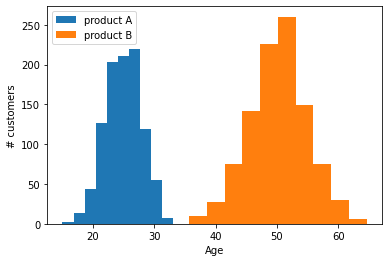

In [ ]:
#Define the function to create the toy dataset. Each feature is a normal distribution.
def create_synth_data(mu_A, mu_B, sig_A, sig_B, N=100, print_flag=False):
  np.random.seed()
  #skin product A mainly used by younger people
  age_A = np.random.normal(mu_A, sig_A, [N, 1]) 
  #skin product B mainly used by older people
  age_B = np.random.normal(mu_B, sig_B, [N, 1]) 
  
  if print_flag: 
    plt.figure()
    plt.hist(age_A, label='product A')
    plt.hist(age_B, label='product B')
    plt.xlabel('Age')
    plt.ylabel('# customers')
    plt.legend()

  X = np.concatenate((age_A, age_B)) 
  y = np.concatenate((np.ones(N,), np.zeros(N,)))
  X, y = shuffle(X, y)
  return X, y 

#Create and visualize the artificial dataset with 1000 samples
mu_A, sig_A = 25, 3
mu_B, sig_B = 50, 5
N = 1000
X, y = create_synth_data(mu_A, mu_B, sig_A, sig_B, N, True)

We can see that the product A is mostly used by younger customers, whereas product B is used by older customers. The number of people who purchase each product is normally distributed around the mean age. We will now fit a logistic regression on our data. 




## **Train logistic regression and monitor accuracy over time**


In [ ]:
#Train logistic regression 
clf = LogisticRegression(random_state=0).fit(X, y)

#Create test set 
N_test = 500
X_test, y_test = create_synth_data(mu_A, mu_B, sig_A, sig_B, N_test, False)
#Display score
accuracy_test = clf.score(X_test, y_test)
print("Accuracy on test set: {}%".format(accuracy_test * 100))

Accuracy on test set: 100.0%


As expected, our logistic regression performs extremely well. This is a very simple task, where the means of the two normal distribution are separate enough that out classifier can easily disambiguate between them.  

Text(0, 0.5, 'accuracy')

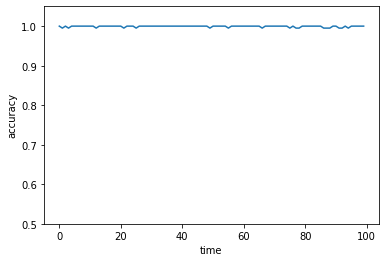

In [ ]:
#Apply logistic regression to new incoming data over a time T
T = 100

#Initialize the performance vector
perf = np.zeros(T)

for i in range(T):
  N = 100
  Xnew, ynew = create_synth_data(mu_A, mu_B, sig_A, sig_B, N)
  perf[i] = clf.score(Xnew, ynew)

#Plot performance over time 
plt.figure()
plt.plot(perf)
plt.ylim(0.5,1.05)
plt.xlabel('time')
plt.ylabel('accuracy')


We now imagine that our model receives a new incoming stream of data, to be classified at each timestep. Since the new data comes from the original distribution, the model's performance is stable over time.

## **Introduce concept drift**


We will now introduce concept drift. Let's assume that some advertisment is made such that product B, orignally meant for an older demographic, becomes popular amongst younger customers as well. This change will alter the relationship between the target variable y and the input data X, as such it is an example of *concept shift*. 

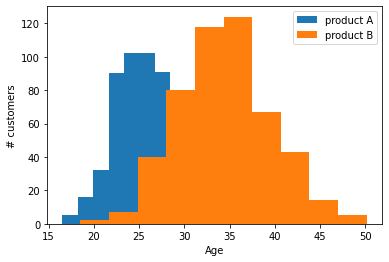

In [ ]:
#@title Slide and run the cell to see how the distribution changes over time
time = 100 #@param {type:"slider", min:0, max:100, step:1}
mu_B_new = 35
M = 500
X1, y1 = create_synth_data(mu_A, mu_B + (mu_B_new - mu_B)/T*time, sig_A, sig_B, M, True)

We model this shift as a gradual change in the mean of the distribution of product B over a total time T. That is, the mean age of product B customers will gradually move from 50 to 35 . You can visualize how the data changes over time by moving the slider and re-running the code.

## **Monitor relevant statistics to detect dataset shift**


---


*Performance, classification confidence and sample mean*

As mentioned in the documentation, monitoring statistics of your model and data can be a very effective way to detect dataset shift.

In [ ]:
#Define new mean age for product B
mu_B_new = 35

#Initialize the variables to monitor 
perf = np.zeros(T)
prob_A, prob_B = np.zeros(T), np.zeros(T)
sample_mean, sample_mean_A, sample_mean_B = np.zeros(T), np.zeros(T), np.zeros(T)

for i in range(T):
  #Define mean at timestep i
  mu_i = mu_B + (mu_B_new - mu_B)/T*i 
  Xnew, ynew = create_synth_data(mu_A,  mu_i, sig_A, sig_B, N)
  
  #Monitor performance 
  perf[i] = clf.score(Xnew, ynew)

  #Monitor classification confidence for each class
  ynew_hat = clf.predict(Xnew)
  Xnew_A, Xnew_B = Xnew[ynew == 1], Xnew[ynew == 0]
  prob_A[i], prob_B[i] = clf.predict_proba(Xnew_A).mean(axis=0)[1], clf.predict_proba(Xnew_B).mean(axis=0)[0]

  #Monitor the mean age of the new data 
  sample_mean[i] = Xnew.mean()
  #Monitor the mean age for each class
  sample_mean_A[i], sample_mean_B[i] = Xnew[ynew==1].mean(), Xnew[ynew==0].mean()

Text(0, 0.5, 'accuracy')

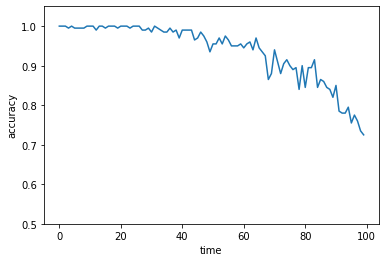

In [ ]:
#@title Accuracy decreases over time
#Plot accuracy over time
plt.figure()
plt.plot(perf)
plt.ylim(0.5,1.05)
plt.xlabel('time')
plt.ylabel('accuracy')

We can see that the accuracy of our model decreases over time. This is the most worrying and most telling sign of dataset shift. It is important to always monitor the performance of the algorithm. Besides plotting, we could have an alert system that automatically triggers a warning or starts retraining if accuracy falls under a certain threshold.

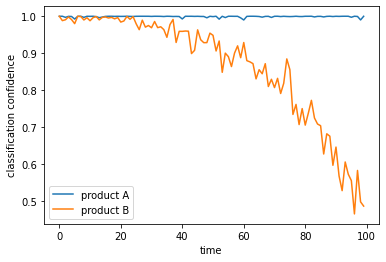

In [ ]:
#@title Classification confidence for product B decreases over time 
plt.figure()
plt.plot(prob_A, label='product A')
plt.plot(prob_B, label='product B')
plt.xlabel('time')
plt.ylabel('classification confidence')
plt.legend()

Another variable that we could monitor is the classification confidence of the model. Here, we can clearly see that the model is confident about recommending product A, but the confidence for product B decays over time. This is a clear indication of dataset shift. 

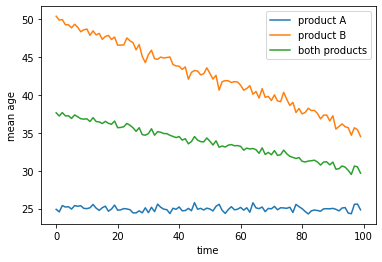

In [ ]:
#@title The mean age for product B decrease over time
plt.figure()
plt.plot(sample_mean_A, label='product A')
plt.plot(sample_mean_B, label='product B')
plt.plot(sample_mean, label='both products')
plt.xlabel('time')
plt.ylabel('mean age')
plt.legend()

Finally, we could consider monitoring statistical properties of the input data itself. Here, we look at the overall sample mean (green line) where we can notice that the overall age of our customer is decreasing. We could decide to then examine the average age for each product. Since the mean age for product A seems to be stable, we would immediately find out that the culprit of our shift lies in the distribution of product B customers. 

## **Statistical tests to compare the old and new data distributions**


---
*Histogram intersection,  Population Stability Index, Kolmogorov-Smirnov statistic*

As mentioned in the documentation, comparing the distributions of the old and new data, can be effective to detect dataset shift.


In [ ]:
#Sample a new dataset of the same size of the old one
N = 1000
Xnew, ynew = create_synth_data(mu_A,  mu_B_new, sig_A, sig_B, N)

### Histogram intersection 

In [ ]:
#Define a function that calculates the intersection between the histogram of the old and the new data 
def histogram_intersection(h1, h2, bins):
  #Normalize histograms 
  dx = np.diff(bins)
  A_h1 = np.sum(dx*h1)
  A_h2 = np.sum(dx*h2)
  h1 = h1/A_h1
  h2 = h2/A_h2
  
  #Calculate histogram intersection 
  HI = np.sum(np.minimum(dx*h1, dx*h2))
  return HI

The Histogram Intersection is: 59.95%


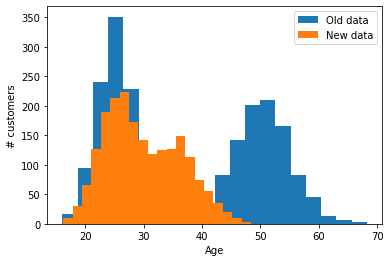

In [ ]:
#Calculate histogram intersection 
nbins = 20
h1, bins, _ = plt.hist(X, nbins, label='Old data')
h2, bins, _ = plt.hist(Xnew, nbins, label='New data')
plt.xlabel('Age')
plt.ylabel('# customers')
plt.legend()

HI = histogram_intersection(h1, h2, bins)
print("The Histogram Intersection is: {}%".format(HI * 100))

It is clear from visual inspection that the two histograms are widely different. The HI statistic allows us to quantify the shift observed in the data, indicating that only approximately 60% of the data overlaps. 

Please note that this intuitive statistics is appropriate for relatively simple cases and it may be difficult to quantify for higher-dimensional datasets.

### Population Stability Index 

In [ ]:
#Define a function that calculates the PSI
def population_stability_index(h1, h2):
  #Normalize histograms 
  dx = np.diff(bins)
  A_h1 = np.sum(dx*h1)
  A_h2 = np.sum(dx*h2)
  h1 = h1/A_h1
  h2 = h2/A_h2

  #Handle possible underflow
  eps = 0.0001
  h1[h1 < eps] = eps
  h2[h2 < eps] = eps

  #Calculate PSI
  PSI = np.sum((h2 - h1)*np.log(h2/h1))
  return PSI

In [ ]:
#Calculate PSI 
PSI = population_stability_index(h2, h1)
print("The Population Stability Index is: {}".format(PSI))

The Population Statistics Index is: 0.8303797748940678


The population statistics index measures how much a variable has shifted over time. These are the usual values: 
*   PSI < 0.1: no significant population change
*  PSI < 0.2: moderate population change
*   PSI >= 0.2: significant population change

In our case, the PSI is strong evidence that a shift in the data has happened. 

### Kolmogorov-Smirnov test

In [ ]:
#Import the stats modul from scipy 
from scipy import stats
#Perform the KS test
KS = stats.ks_2samp(X.squeeze(), Xnew.squeeze())
print("The Kolmogorov-Smirnov test rejects the null hypothesis with a p-value: {}%".format(KS.pvalue))

The Kolmogorov-Smirnov test rejects the null hypothesis with a p-value: 1.2067197058552138e-180%


The test strongly rejects the hypothesis that these data comes from the same distribution. As such, it is a strong warning that there has been a dataset shift. 

## **Detect concept drift with ADWIN and retrain model**

In [ ]:
from skmultiflow.drift_detection.adwin import ADWIN
adwin = ADWIN()

#Initialize variables
T = 1000
perf, perf_retrain = np.zeros((T)), np.zeros((T))
index_change = []

#Fit a new logistic regression that we will retrain (keep the old one as baseline)
clf_retrain = LogisticRegression(random_state=0).fit(X, y)

for i in range(T):
  #Mumber of samples at each timestep
  N = 150
  
  #Define mean at timestep i
  mu_i = mu_B + (mu_B_new - mu_B)/T*i 
  Xnew, ynew = create_synth_data(mu_A,  mu_i, sig_A, sig_B, N)
  
  #Store performance
  perf[i], perf_retrain[i]  = clf.score(Xnew, ynew), clf_retrain.score(Xnew, ynew)

  #Add each sample to ADWIN 
  for j in range(N*2):
    adwin.add_element(Xnew[j].squeeze())

  #Check if ADWIN detects a change in the distribution at timestep i
  if adwin.detected_change():
    #Store indices where change is detected
    index_change.append(i)
    #If change detected, retrain
    clf_retrain.fit(Xnew, ynew)

ADWIN detected changes in the data, and the model was retrained, at timesteps: [191, 223, 255, 319, 351, 383, 415, 447, 479, 511, 543, 575, 607, 639, 671, 703, 735, 767, 799, 831, 863, 895, 927, 959, 991]


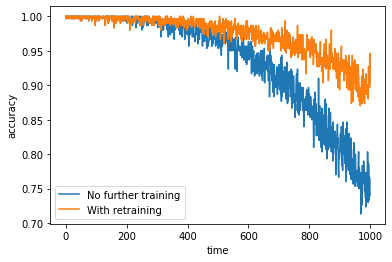

In [ ]:
plt.figure()
plt.plot(perf, label='No further training')
plt.plot(perf_retrain, label='With retraining')
plt.xlabel('time')
plt.ylabel('accuracy')
plt.legend()

print("ADWIN detected changes in the data, and the model was retrained, at timesteps: {}".format(index_change))


[ADWIN](https://scikit-multiflow.readthedocs.io/en/stable/api/generated/skmultiflow.drift_detection.ADWIN.html) is able to detect changes in the data by comparing successive time windows. Whenever this happens, retraining is triggered. We can see that the model with retraining clearly outperforms the original model. 

It is important to notice that the new task is much harder than the original task, i.e. the mean ages of the two groups are now closer and therefore more difficult to differentiate. As such, we should not be discouraged when seeing that the performance of our model isn't as good as it was at time 0.  